### Libraries

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

import numpy as np
from numpy import trace
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import mnist
import keras.backend as K
from keras.layers import Input, Dense, Lambda
from keras.layers import Flatten, Reshape
from keras.layers import BatchNormalization, Dropout
from PIL import Image as im
from numpy import cov
from numpy import asarray
from skimage.transform import resize
from itertools import chain
import random
from tensorflow.keras.optimizers import Adam

### Normalizing the training set

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

for i in range(32):
    x_train = np.insert(x_train, len(x_train)-1, x_test[i], axis = 0)

x_train = x_train / 255

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
for i in range(32):
    y_train = np.insert(y_train, len(y_train)-1, y_test[i], axis = 0)


In [ ]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))

In [ ]:
print(x_train.shape)

(60032, 28, 28, 1)


If the error message "You are passing KerasTensor ..." appeared, recompile the 2 cells prior to the training section and then retrain the model.

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
######################################### If you are facing more errors

In [ ]:
# import tensorflow._api.v2.compat.v1 as tf_dis

# tf_dis.disable_v2_behavior()

### VAE components and methods

In [ ]:
batch_size = 128
hidden_dim = 2 # Since we are in 2D space (images), the dimensions of mean and var are 2
n_epochs = 60

def dropout_and_batchnorm(x):
    return Dropout(0.3)(BatchNormalization()(x))

def prior(args):
    mean, log_var, batch_size, hidden_dim = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(log_var / 2) * N + mean

In [ ]:
class VAE:
    def __init__(self, batch_size_, hidden_dim_, epochs_):
        self.batch_size = batch_size_
        self.hidden_dim = hidden_dim_
        self.epochs = epochs_
        self.input_image = Input(batch_shape=(self.batch_size, 28, 28, 1))
        self.encoder, self.latent_space = self.build_the_encoder()
        self.decoder = self.build_the_decoder()

    def build_the_encoder(self):
        x = Flatten()(self.input_image)
        x = Dense(256, activation="relu")(x)
        x = dropout_and_batchnorm(x)
        x = Dense(128, activation="relu")(x)
        x = dropout_and_batchnorm(x)
        # Our prior distribution is N(mean_of_batch, var_of_batch)
        self.mean = Dense(self.hidden_dim)(x)
        self.log_var = Dense(self.hidden_dim)(x)
        # print("K eval: ", K.eval(self.mean))
        # The latent space
        latent_space = Lambda(prior, output_shape=(self.hidden_dim))([self.mean, self.log_var, self.batch_size, self.hidden_dim])
        # The encoder built based on the latent space
        encoder = keras.Model(self.input_image, latent_space)
        return encoder, latent_space

    def build_the_decoder(self):
        input_decoder = Input(shape=(self.hidden_dim,))
        d = Dense(128, activation="relu")(input_decoder)
        d = dropout_and_batchnorm(d)
        d = Dense(256, activation="relu")(d)
        d = dropout_and_batchnorm(d)
        d = Dense(28*28, activation="sigmoid")(d)
        # The final layer
        decoded_image = Reshape((28, 28, 1))(d)
        decoder = keras.Model(input_decoder, decoded_image)
        return decoder

    def loss(self, main, reconstructed):
        main = K.reshape(main, shape=(self.batch_size, 28*28))
        reconstructed = K.reshape(reconstructed, shape=(self.batch_size, 28*28))
        reconstruction_loss = K.sum(K.square(main-reconstructed), axis=-1)
        kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mean) - K.exp(self.log_var), axis=-1)
        return reconstruction_loss + kl_loss

In [ ]:
vae = VAE(batch_size, hidden_dim, n_epochs)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
latent_sp = vae.encoder(vae.input_image)
model = keras.Model(vae.input_image, vae.decoder(latent_sp))
model.compile(optimizer= "adam", loss=vae.loss)

### Training the VAE
(Trained with A100 Because of the Calc_FID problem)

In [ ]:
import time
start_time = time.time()
model.fit(x_train, x_train, epochs=vae.epochs, batch_size = vae.batch_size, shuffle=True)
end_time = time.time()
exe_time = end_time - start_time

Train on 60032 samples
Epoch 1/60
60032/60032 [==============================] - 6s 100us/sample - loss: 83.2530
Epoch 2/60
60032/60032 [==============================] - 3s 47us/sample - loss: 49.2880
Epoch 3/60
60032/60032 [==============================] - 3s 48us/sample - loss: 46.7115
Epoch 4/60
60032/60032 [==============================] - 3s 47us/sample - loss: 45.2751
Epoch 5/60
60032/60032 [==============================] - 3s 47us/sample - loss: 44.2876
Epoch 6/60
60032/60032 [==============================] - 3s 48us/sample - loss: 43.5551
Epoch 7/60
60032/60032 [==============================] - 3s 49us/sample - loss: 43.1047
Epoch 8/60
60032/60032 [==============================] - 3s 48us/sample - loss: 42.7620
Epoch 9/60
60032/60032 [==============================] - 3s 47us/sample - loss: 42.4173
Epoch 10/60
60032/60032 [==============================] - 3s 47us/sample - loss: 42.1632
Epoch 11/60
60032/60032 [==============================] - 3s 48us/sample - loss: 41.

In [ ]:
print("Exec Time: ", exe_time)

Exec Time:  176.3504056930542


### Sampling from the Latent

In [ ]:
def sample_from(number_of_samples, interval, seed):
    random.seed(seed)
    points = [random.randrange(interval[0], interval[1]) for _ in range(2*number_of_samples)]
    samples = []
    for i in range(0, 2*number_of_samples, 2):
        samples.append([points[i], points[i+1]])
    return samples

In [ ]:
def plot_distribution(vae, points, save, show, series):
    n =  2
    size = 2*n
    num = 1
    plt.figure(figsize=(size, size))
    start = time.time()
    for i in range(-n, n+1):
        for j in range(-n, n+1):
            if(num > len(points)): continue
            image = vae.decoder.predict(np.expand_dims(points[num-1], axis=0))
            # global fid_score_list
            # if len(fid_score_list) == 0:
            #   fid_score_list = image
            # elif len(fid_score_list) > 0:
            #   fid_score_list = np.append(fid_score_list, image, axis = 0)
            # if save:
            #     plt.figure(figsize=(size/2, size/2))
            #     image_name = path_to_save + '/'+str(vae.epochs)+"_"+str(vae.batch_size)+"_label_"+str(num - 1)+"_"+ str(series) +".png"
            #     plt.imshow(image.squeeze(), cmap="gray")
            #     plt.savefig(image_name)
            #     plt.close()
            if show:
                ax = plt.subplot(size, size, num)
                plt.imshow(image.squeeze(), cmap="gray")
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                # plt.show()
                # plt.close() # If the images were not shown, comment this line
                num += 1

    end = time.time()
    exe_time = end - start
    if save == False and show == False:
        return exe_time

### Generating Samples

In [ ]:
number_of_samples = 16
infinity_interval = [int(-1e6), int(1e6)]
bad_samples = sample_from(number_of_samples, infinity_interval, seed = 0)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


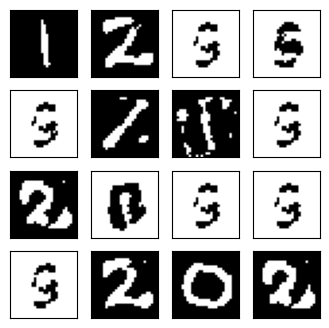

In [ ]:
plot_distribution(vae, bad_samples, False, True, series = 0) # If the images were not shown, comment this line

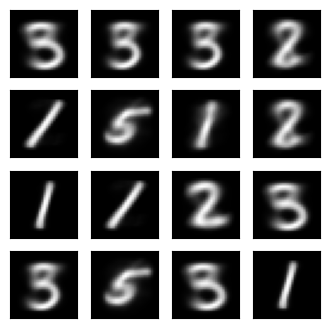

In [ ]:
good_interval = [0, 3]
better_samples = sample_from(number_of_samples, good_interval, seed = 1)
plot_distribution(vae, better_samples, False, True, series = 1)

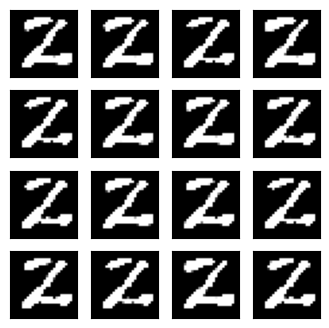

In [ ]:
interval = [80, 100]
better_samples = sample_from(number_of_samples, interval, seed = 20)
plot_distribution(vae, better_samples, False, True, series = 20)

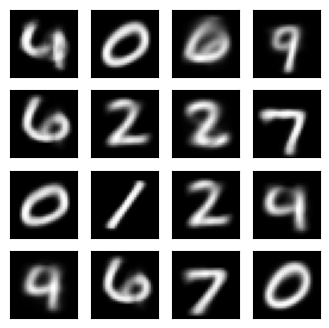

In [ ]:
samples = sample_from(number_of_samples, [-4, 4], seed = 2)
plot_distribution(vae, samples, False, True, series = 2)

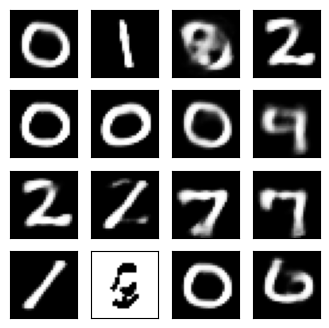

In [ ]:
samples = sample_from(number_of_samples, [-10, 10], seed = 3)
plot_distribution(vae, samples, False, True, series = 3)

### Inference Time

In [ ]:
def scatter(first_axis, second_axis, title):
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.scatter(first_axis, second_axis, marker = '.')

In [ ]:
inference_times = []
number_of_runs = 100

In [ ]:
seed = 10
seri = 10
for i in range(number_of_runs):
    thresh = 1e6
    samples = sample_from(number_of_samples, [-thresh, thresh], seed)
    inf_time = plot_distribution(vae, samples, False, False, series = seri)
    seed += 1
    seri += 1
    inference_times.append(inf_time)

In [ ]:
scatter(np.arange(0,len(inference_times)), inference_times, "Inference execution times")

In [ ]:
print("Mean inference time: ", round(sum(inference_times)/len(inference_times), 4))

### FID Score

In [ ]:
fid_score_list = []

In [ ]:
n = 49
size = 2*n+1

num = 1
# plt.figure(figsize=(size * 1.5, size * 1.5))
for i in range(-n, n+1):
    for j in range(-n, n+1):
        # ax = plt.subplot(size, size, num)
        num += 1
        image = vae.decoder.predict(np.expand_dims([3*i/n, 3*j/n], axis=0))
        fid_score_list.append(image[0])
        # print("Shape : ", np.asarray(fid_score_list).shape)
        # plt.imshow(image.squeeze(), cmap="gray")
        # plt.title(str(i) + "&&" + str(j))
        # ax.get_xaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)

In [ ]:
fid_score_list = np.asarray(fid_score_list)
print(fid_score_list.shape)
print(x_train.shape)

(9801, 28, 28, 1)
(60032, 28, 28, 1)


In [ ]:
from fid import FID_measure
import random
import gc

In [ ]:
fid = FID_measure(gen_images_ = fid_score_list, train_set_ = x_train, labels_ = y_train)
train_set_shrinked, train_set_shrinked_labels = fid.sample_uniformly(num_sample_per_class = int(len(fid_score_list)/10))

Middle of Constructor
Train set len :  60032
End of Constructor
Middle of sample uniformly
Train set len :  9800
End of sample uniformly


In [ ]:
score = fid.calculate_fid()
print('FID: %.3f' % score)

beginning of calc_fid
gen_images len :  9801
Check whether shrink is not None
Train set len :  9800
87910968/87910968 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


gen_images solved
train_set solved
sigma1 solved
sigma2 solved
FID: 21.477


### Calculating Mean and Variance of Distributions

In [ ]:
def calc_mu_and_sigma(dataset):
    # The returned sigma is the covariance matrix and mu is the mean
    flatten_images = []

    for i in range(len(dataset)):
        vectorize = np.array(list(chain.from_iterable(dataset[i])))
        flatten_images.append(vectorize)

    flatten_images = np.array(flatten_images)
    print("Flatten images: ", flatten_images.shape)
    mu = flatten_images.mean(axis = 0)
    print("Mu: ", mu.shape)
    sigma = np.dot(flatten_images[0], flatten_images[0].T)

    print("Sigma: ", sigma.shape)

    for i in range(1, len(flatten_images)):
        Ui = np.dot(flatten_images[i], flatten_images[i].T)
        sigma += Ui

    mu_mu_T = np.dot(mu, mu.T)
    sigma = sigma / len(dataset)
    sigma = sigma - mu_mu_T

    return mu, sigma, flatten_images

In [ ]:
mu_train, sigma_train, vectorized_train = calc_mu_and_sigma(train_set_shrinked)

Flatten images:  (9800, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
mu_gen, sigma_gen, vectorized_gen = calc_mu_and_sigma(fid_score_list)

Flatten images:  (9801, 784, 1)
Mu:  (784, 1)
Sigma:  (784, 784)


In [ ]:
from scipy.linalg import sqrtm

diff_mean = np.sum(np.square(mu_train - mu_gen))

dot_of_sigmas = np.dot(sigma_train, sigma_gen.T)

diff_cov = sigma_train + sigma_gen - 2*sqrtm(dot_of_sigmas)

print("FID score of VAE with ", n_epochs, " epochs and ", batch_size, " batch size:\n", round(np.absolute(diff_mean + trace(diff_cov)), 4))

FID score of VAE with  60  epochs and  128  batch size:
 26.7511


### CNN for Predicting Generated Images

In [ ]:
from keras.models import load_model
cnn = load_model('CNN.h5')

In [ ]:
preds_gen = cnn.predict(fid_score_list)
pred_labels_gen = np.argmax(preds_gen, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
unique_elements, counts = np.unique(pred_labels_gen, return_counts=True)
frequency = dict(zip(unique_elements, counts))
print("Frequency of Elements: ")
print(frequency)

Frequency of Elements: 
{0: 1871, 1: 2384, 2: 994, 3: 424, 4: 364, 5: 204, 6: 1819, 7: 996, 8: 432, 9: 313}


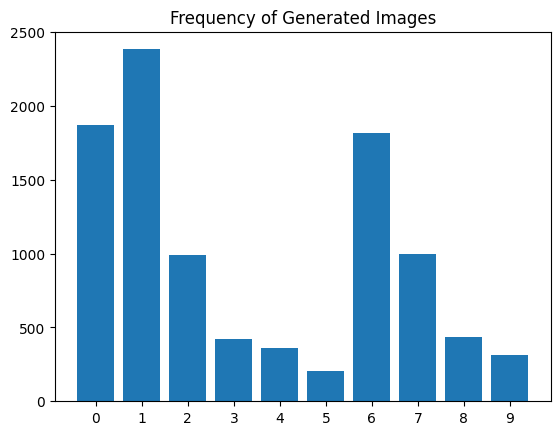

In [ ]:
plt.bar(unique_elements, counts)
plt.xticks(np.arange(10))
plt.title('Frequency of Generated Images')
plt.show()

### Viewing Dimension-Reduced Generated Samples

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def scatter(first_axis, second_axis, labels, title):
    plt.figure(figsize=(10, 8))
    unique_classes = set(labels)
    plt.title(title)
    colors = ["red", "green", "blue", "yellow", "pink", "black", "orange", "purple", "cyan", "magenta"]
    for i, class_label in enumerate(unique_classes):
        class_indices = [j for j, c in enumerate(labels) if c == class_label]
        plt.scatter([first_axis[idx] for idx in class_indices],
                    [second_axis[idx] for idx in class_indices],
                    color=colors[i % len(colors)],
                    label=f'Class {class_label}')

    plt.legend()
    plt.show()


def map_diversity(data, variance_PCA):
    if data.ndim == 3:
        data = data.squeeze()
    pca = PCA(n_components = variance_PCA)
    reduced_vectors_pca = pca.fit_transform(data)
    # print(pca.n_components_) # If interested
    tsne = TSNE(n_components=2)
    reduced_vectors_tsne = tsne.fit_transform(reduced_vectors_pca)
    return reduced_vectors_tsne

In [ ]:
reduced_dimension_gen = map_diversity(data = vectorized_gen, variance_PCA = 0.85)

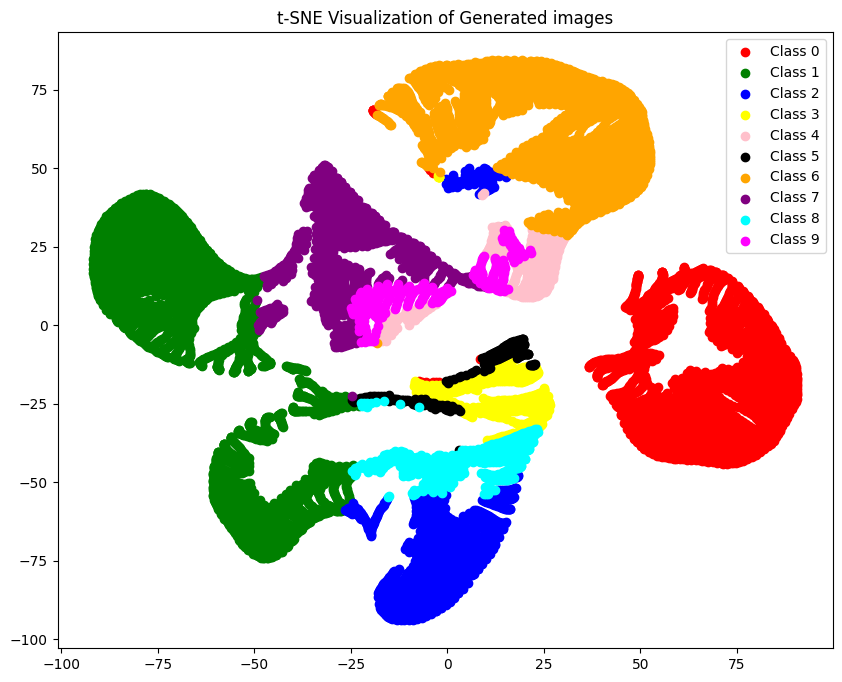

In [ ]:
scatter(reduced_dimension_gen[:, 0], reduced_dimension_gen[:, 1], pred_labels_gen, 't-SNE Visualization of Generated images')

In [ ]:
reduced_dimension_train = map_diversity(data = vectorized_train, variance_PCA = 0.85)

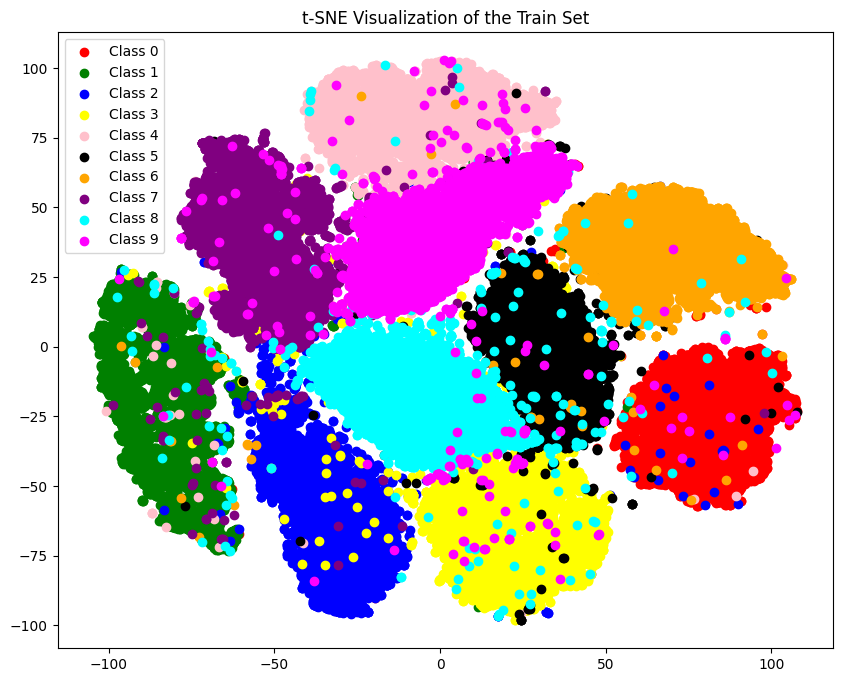

In [ ]:
scatter(reduced_dimension_train[:, 0], reduced_dimension_train[:, 1], y_train, 't-SNE Visualization of the Train Set')

### Density, Coverage, Recall, Precision Parameters

In [ ]:
print(reduced_dimension_train.shape)
print(reduced_dimension_gen.shape)

(9800, 2)
(9801, 2)


In [ ]:
gc.collect()

1184

In [ ]:
!pip3 install prdc

from prdc import compute_prdc

In [ ]:
# _, _, vectorized_train_shrinked = calc_mu_and_sigma(train_set_shrinked)
# reduced_dimension_train_shrinked = map_diversity(data = vectorized_train_shrinked, variance_PCA = 0.85)

In [ ]:
for j in np.asarray([5, 10, 6, 3, 2, 1]):
    print(j, "-Nearest Neighbors")
    metrics = compute_prdc(real_features = reduced_dimension_train,
                          fake_features = reduced_dimension_gen,
                          nearest_k=j)

    print(metrics)
    print("\n----------------------------------\n")

5 -Nearest Neighbors
Num real: 9800 Num fake: 9801
{'precision': 0.6048362411998776, 'recall': 0.523061224489796, 'density': 0.5190286705438221, 'coverage': 0.4928571428571429}

----------------------------------

10 -Nearest Neighbors
Num real: 9800 Num fake: 9801
{'precision': 0.6534027140087746, 'recall': 0.5944897959183674, 'density': 0.5095806550352004, 'coverage': 0.5678571428571428}

----------------------------------

6 -Nearest Neighbors
Num real: 9800 Num fake: 9801
{'precision': 0.6191204979083766, 'recall': 0.5425510204081633, 'density': 0.5217154712104206, 'coverage': 0.5141836734693878}

----------------------------------

3 -Nearest Neighbors
Num real: 9800 Num fake: 9801
{'precision': 0.5385164779104173, 'recall': 0.4746938775510204, 'density': 0.47954290378532805, 'coverage': 0.39683673469387754}

----------------------------------

2 -Nearest Neighbors
Num real: 9800 Num fake: 9801
{'precision': 0.43526170798898073, 'recall': 0.41489795918367345, 'density': 0.41740638